# Man-Woman Detection
Transfer Learning + Data Augmentation

In [29]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, Model, Sequential, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

## Download and prepare dataset

### Download dataset from Kaggle

In [2]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d saadpd/menwomen-classification

 99% 795M/806M [00:10<00:00, 115MB/s]
100% 806M/806M [00:10<00:00, 79.7MB/s]


In [5]:
!unzip -qq menwomen-classification.zip

In [6]:
import os

num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'Train: men: {num_men_train} | women: {num_women_train}')
print(f'Test: men: {num_men_test} | women: {num_women_test}')

Train: men: 1000 | women: 1912
Test: men: 418 | women: 915


### Create dataset directories

In [7]:
import shutil, pathlib

new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
            os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(base_dir, category, fname),
            dst=os.path.join(dir, fname))

In [8]:
make_subset("traindata/traindata", "validation", start_index=0, end_index=200)
make_subset("traindata/traindata", "train", start_index=200, end_index=1000)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

### Create Train/Validation/Test datasets

In [9]:
print('Train loader:')
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)
print('Validation loader:')
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)
print('Test loader:')
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)

Train loader:
Found 1600 files belonging to 2 classes.
Validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


In [15]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

### Visualize some images/labels

data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


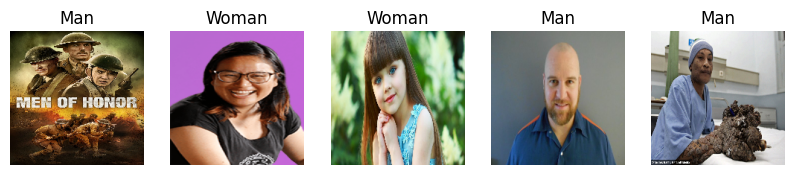

In [22]:
# Get one batch (containing 32 random images) from training dataset
# You will get different set of images on each run of this cell
for data_batch, label_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('label batch shape:', label_batch.shape)

    # Show five random examples of the loaded batch
    fig, axes = plt.subplots(1, 5, figsize=(10,3))
    for i, ax in enumerate(axes):
        ax.imshow(data_batch[i].numpy().astype('uint8'))
        ax.set_axis_off()
        ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
    break

plt.show()

## Model Design

### Using VGG16 as base model

In [10]:
conv_base = VGG16(weights='imagenet', include_top=False,
                   input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Calculate features from images

In [12]:
import numpy as np
from tensorflow import keras
from tqdm import tqdm

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in tqdm(dataset):
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


In [13]:
train_features.shape

(1600, 5, 5, 512)

#### Classification model

In [15]:
inputs = layers.Input(shape=(5, 5, 512))
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 131585 (514.00 KB)
Trainable params: 131585 (514.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

#### Train classification model with feature data

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
my_callbacks = [
    callbacks.ModelCheckpoint(
        filepath="convnet_transfer_learning.h5",
        save_best_only=True,
        monitor="val_loss")
]

In [21]:
history1 = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=my_callbacks,
    batch_size=32
)

Epoch 1/30
50/50 [==============================] - 3s 10ms/step - loss: 1.2551 - accuracy: 0.7356 - val_loss: 0.4506 - val_accuracy: 0.8650
Epoch 2/30
46/50 [==========================>...] - ETA: 0s - loss: 0.5680 - accuracy: 0.8349

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 0s 5ms/step - loss: 0.5671 - accuracy: 0.8356 - val_loss: 0.3369 - val_accuracy: 0.8825
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.3518 - accuracy: 0.8838 - val_loss: 0.3513 - val_accuracy: 0.8825
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2625 - accuracy: 0.9013 - val_loss: 0.3450 - val_accuracy: 0.8850
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2253 - accuracy: 0.9094 - val_loss: 0.3305 - val_accuracy: 0.8825
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1405 - accuracy: 0.9463 - val_loss: 0.3109 - val_accuracy: 0.8850
Epoch 7/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1440 - accuracy: 0.9369 - val_loss: 0.3076 - val_accuracy: 0.8800
Epoch 8/30
50/50 [==============================] - 0s 5ms/step - loss: 0.0913 - accuracy: 0.9675 - val_loss: 0.3212 - val_accuracy: 0.8875
Epoch 9/30
50/50 [=============

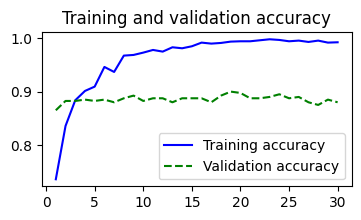

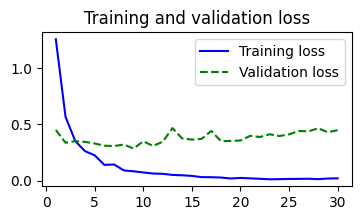

In [25]:
accuracy = history1.history["accuracy"]
val_accuracy = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(4, 2))
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "g--", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(4, 2))
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "g--", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [29]:
# model_best = load_model('convnet_transfer_learning.h5')
model.evaluate(test_features, test_labels)

25/25 [==============================] - 0s 4ms/step - loss: 0.3076 - accuracy: 0.9262


[0.3075748383998871, 0.9262499809265137]

### Transfer Learning + Data Augmentation

#### Data augmentation model

In [12]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [16]:
# Freeze the base model
conv_base.trainable = False

#### Full model
including Augmentation + VGG16 + classification layers

In [17]:
inputs = layers.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=inputs, outputs=outputs)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0   

#### Training Step 1
only the classification head

In [18]:
model2.compile(loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])

In [19]:
my_callbacks2 = [
    callbacks.ModelCheckpoint(
        filepath="convnet_transfer_learning_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]

In [20]:
history2 = model2.fit(train_dataset,
                      epochs=30,
                      validation_data=validation_dataset,
                      callbacks=my_callbacks2)

Epoch 1/30
50/50 [==============================] - 30s 338ms/step - loss: 1.2068 - accuracy: 0.6794 - val_loss: 0.5040 - val_accuracy: 0.8725


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
50/50 [==============================] - 18s 342ms/step - loss: 0.5832 - accuracy: 0.7950 - val_loss: 0.4002 - val_accuracy: 0.8575
Epoch 3/30
50/50 [==============================] - 17s 300ms/step - loss: 0.4317 - accuracy: 0.8244 - val_loss: 0.3549 - val_accuracy: 0.8875
Epoch 4/30
50/50 [==============================] - 17s 319ms/step - loss: 0.3774 - accuracy: 0.8369 - val_loss: 0.3324 - val_accuracy: 0.8800
Epoch 5/30
50/50 [==============================] - 16s 303ms/step - loss: 0.3265 - accuracy: 0.8487 - val_loss: 0.3561 - val_accuracy: 0.8925
Epoch 6/30
50/50 [==============================] - 16s 302ms/step - loss: 0.3112 - accuracy: 0.8706 - val_loss: 0.3605 - val_accuracy: 0.8725
Epoch 7/30
50/50 [==============================] - 18s 330ms/step - loss: 0.2821 - accuracy: 0.8694 - val_loss: 0.4005 - val_accuracy: 0.8525
Epoch 8/30
50/50 [==============================] - 16s 294ms/step - loss: 0.2895 - accuracy: 0.8731 - val_loss: 0.3373 - val_accuracy: 0.8875

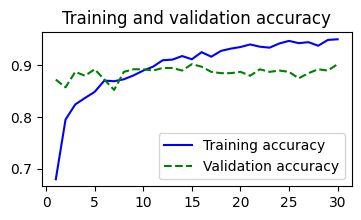

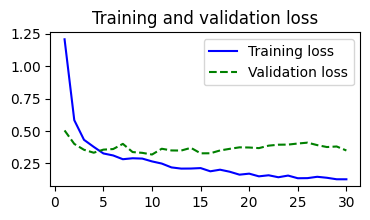

In [34]:
accuracy = history2.history["accuracy"]
val_accuracy = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(4, 2))
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "g--", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(4, 2))
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "g--", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [23]:
model2.evaluate(test_dataset)

25/25 [==============================] - 7s 178ms/step - loss: 0.3384 - accuracy: 0.9013


[0.3384125828742981, 0.9012500047683716]

#### Un-freeze the last conv block of VGG16

In [27]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [28]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0   

#### Training Step 2
Fine-tune the un-freezed layers + classification head

In [30]:
model2.compile(loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"])

In [31]:
my_callbacks3 = [
    callbacks.ModelCheckpoint(
        filepath="convnet_transfer_learning_augmentation_2.h5",
        save_best_only=True,
        monitor="val_loss")
]

In [32]:
history3 = model2.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=my_callbacks3)

Epoch 1/25
50/50 [==============================] - 23s 345ms/step - loss: 0.1390 - accuracy: 0.9463 - val_loss: 0.4613 - val_accuracy: 0.8750


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/25
50/50 [==============================] - 19s 340ms/step - loss: 0.1119 - accuracy: 0.9550 - val_loss: 0.3500 - val_accuracy: 0.9050
Epoch 3/25
50/50 [==============================] - 16s 296ms/step - loss: 0.0882 - accuracy: 0.9663 - val_loss: 0.3508 - val_accuracy: 0.9100
Epoch 4/25
50/50 [==============================] - 17s 310ms/step - loss: 0.0801 - accuracy: 0.9694 - val_loss: 0.3634 - val_accuracy: 0.9100
Epoch 5/25
50/50 [==============================] - 17s 311ms/step - loss: 0.0774 - accuracy: 0.9688 - val_loss: 0.4448 - val_accuracy: 0.9000
Epoch 6/25
50/50 [==============================] - 17s 305ms/step - loss: 0.0765 - accuracy: 0.9712 - val_loss: 0.3671 - val_accuracy: 0.9100
Epoch 7/25
50/50 [==============================] - 17s 310ms/step - loss: 0.0848 - accuracy: 0.9644 - val_loss: 0.3587 - val_accuracy: 0.9150
Epoch 8/25
50/50 [==============================] - 17s 309ms/step - loss: 0.0853 - accuracy: 0.9731 - val_loss: 0.4138 - val_accuracy: 0.9175

#### History of both steps together

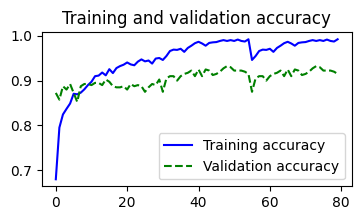

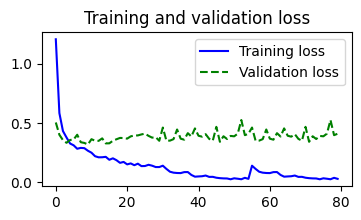

In [36]:
accuracy2 = history3.history["accuracy"]
val_accuracy2 = history3.history["val_accuracy"]
loss2 = history3.history["loss"]
val_loss2 = history3.history["val_loss"]

accuracy.extend(accuracy2)
val_accuracy.extend(val_accuracy2)
loss.extend(loss2)
val_loss.extend(val_loss2)

plt.figure(figsize=(4, 2))
plt.plot(accuracy, "b", label="Training accuracy")
plt.plot(val_accuracy, "g--", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(4, 2))
plt.plot(loss, "b", label="Training loss")
plt.plot(val_loss, "g--", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Final Evaluation

In [39]:
model2_best = load_model('convnet_transfer_learning_augmentation_2.h5')
model2_best.evaluate(test_dataset)

25/25 [==============================] - 7s 203ms/step - loss: 0.2520 - accuracy: 0.9525


[0.25200045108795166, 0.9524999856948853]